In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
def compute_steering_vectors(angles, frequencies, mic_pos, speed_sound=343.):
    NUM_FREQS = len(frequencies)
    NUM_ANGLES = len(angles)
    NUM_MICS = len(mic_pos)
    angles_rad = np.deg2rad(angles)
    far_delays = -(np.kron(np.cos(angles_rad), np.array([mic_pos[:,0]]).T)+ \
                   np.kron(np.sin(angles_rad), np.array([mic_pos[:,1]]).T))/speed_sound
    far_delays = far_delays.T
    steer = np.zeros([NUM_FREQS, NUM_ANGLES, NUM_MICS], dtype=complex)
    for k in range(NUM_FREQS):
        steer[k, :, :] = np.exp(-1j*2*np.pi*frequencies[k]*far_delays)
    return steer

In [3]:
def compute_freq_resp(weights, angles, loc, fs, freqs=None, c=343.):
#computeFreqResp Compute the frequency response of a set of weights for a
# particular look direction (angle).
#
#   Args: 
#       weights : weights for beamforming.
#              This should be a matrix of size M by F where M is the number
#              of microphones and F is the number of frequency bins 
#              (nfft/2+1).
#       angles : lok directions (in degrees) for which to compute the
#                frequency response.
#       loc : microphone positions (in meters)
#             M by 2 matrix where M is the number of microphones
#       fs : Sampling frequency (Hz).
#       freqs : Frequencies (HZ) over which to compute the frequency response.
#                Default is logspace(1,log10(fs/2),150).
#       c : Speed of sound (m/s). Default is 343.
#       plt : boolean for whether or not to plot. Default is 'true'.
#
#   Returns:
#       freqResp : frequency response in a particular look direction.
#
#   Example:
#       >> % compute weights before
#       >> freqResp = computeFreqResp(W, angles, loc, fs);
    if freqs == None:
        freqs = np.linspace(100, 8000, 80)
    nFreq = len(freqs)
    chs, nBins = np.shape(weights)
    nfft = (nBins-1)*2
    nAngs = len(angles)
    #compute capture/steering vector (far-field)
    freqResp = np.zeros([nAngs,nFreq])
    steer = compute_steering_vectors(angles, freqs, loc, c)
    for t in range(nAngs):
        for k in range(nFreq):
            # convert to index for corresponding weights
            fidx = np.int(np.round(freqs[k]/fs*nfft))
            freqResp[t, k] = np.abs(np.dot(steer[k, t], weights[:, fidx]))
        freqResp[t, :] = 20*np.log10(freqResp[t,:])
    return freqResp,freqs


In [4]:
weights_dspc_2cm = pd.read_csv("./weights/weight_2cm.csv", header=None).values.astype(str).astype(np.complex)
weights_dspc_2cm = weights_dspc_2cm.T
angles = np.linspace(0,360, 61)
FreqsEval = np.linspace(100, 8000, 80)
# 2cm min end-fire
mic_pos = np.array([[-0.01, 0],[0.01, 0]])
freq_samp = 16000.

FreqResp_BF_2cmDSPC, freqs = compute_freq_resp(weights_dspc_2cm, angles, mic_pos, freq_samp)

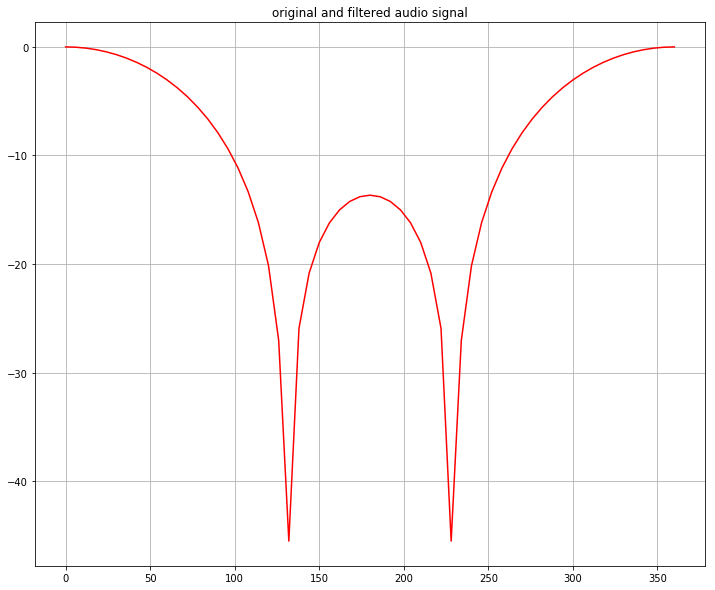

In [5]:
fig = plt.figure(figsize=(12,10))
plt.title("original and filtered audio signal")
#plt.plot(local_test_sig, 'b')
plt.plot(angles, FreqResp_BF_2cmDSPC[:,9], 'r')
#plt.legend(('original', 'filtered'), loc='best')
plt.grid(True)
plt.show()

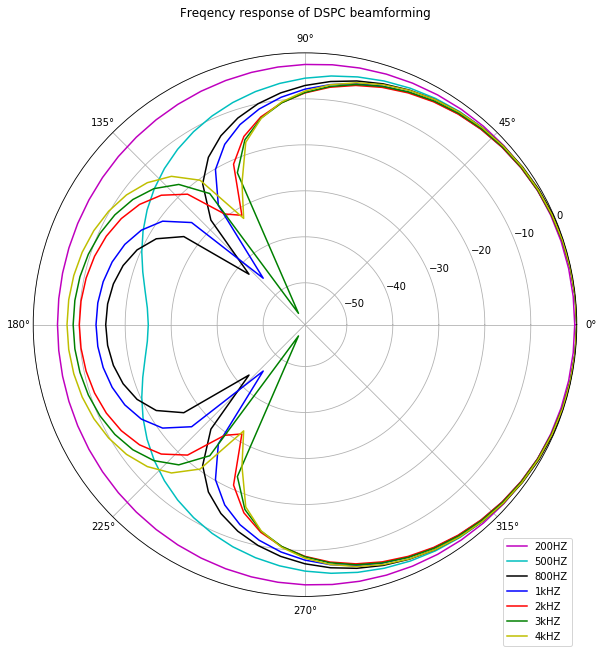

In [6]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, polar=True)
ax.plot(np.deg2rad(angles), FreqResp_BF_2cmDSPC[:,1], 'm', label='200HZ')
ax.plot(np.deg2rad(angles), FreqResp_BF_2cmDSPC[:,4], 'c', label='500HZ')
ax.plot(np.deg2rad(angles), FreqResp_BF_2cmDSPC[:,7], 'k', label='800HZ')
ax.plot(np.deg2rad(angles), FreqResp_BF_2cmDSPC[:,9], 'b', label='1kHZ')
ax.plot(np.deg2rad(angles), FreqResp_BF_2cmDSPC[:,19], 'r', label='2kHZ')
ax.plot(np.deg2rad(angles), FreqResp_BF_2cmDSPC[:,29], 'g', label='3kHZ')
ax.plot(np.deg2rad(angles), FreqResp_BF_2cmDSPC[:,39], 'y', label='4kHZ')
#ax.set_rmin(-50)
ax.set_rmax(0)
ax.grid(True)
ax.set_title("Freqency response of DSPC beamforming", va='bottom')
ax.legend(loc="lower right",bbox_to_anchor=(1.0, -0.1))
plt.show()

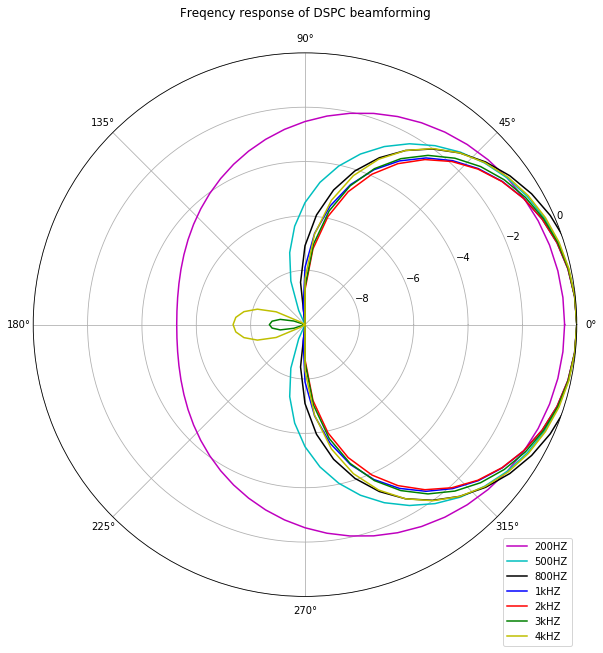

In [7]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, polar=True)
ax.plot(np.deg2rad(angles), np.maximum(FreqResp_BF_2cmDSPC[:,1], -10), 'm', label='200HZ')
ax.plot(np.deg2rad(angles), np.maximum(FreqResp_BF_2cmDSPC[:,4], -10), 'c', label='500HZ')
ax.plot(np.deg2rad(angles), np.maximum(FreqResp_BF_2cmDSPC[:,7], -10), 'k', label='800HZ')
ax.plot(np.deg2rad(angles), np.maximum(FreqResp_BF_2cmDSPC[:,9], -10), 'b', label='1kHZ')
ax.plot(np.deg2rad(angles), np.maximum(FreqResp_BF_2cmDSPC[:,19], -10), 'r', label='2kHZ')
ax.plot(np.deg2rad(angles), np.maximum(FreqResp_BF_2cmDSPC[:,29], -10), 'g', label='3kHZ')
ax.plot(np.deg2rad(angles), np.maximum(FreqResp_BF_2cmDSPC[:,39], -10), 'y', label='4kHZ')
ax.set_rmin(-10)
ax.set_rmax(0)
ax.grid(True)
ax.set_title("Freqency response of DSPC beamforming", va='bottom')
ax.legend(loc="lower right",bbox_to_anchor=(1.0, -0.1))
plt.show()

Execute Beamforming on signal

In [8]:
import serial
import IPython.display as ipd

In [9]:
port = '/dev/tty.usbmodem0004830868271'

serialPort = serial.Serial(port = port, baudrate=115200,
                           bytesize=8, timeout=2, stopbits=serial.STOPBITS_ONE)

Get PCM samples from Apollo 3

In [14]:
serialString = ""     # Used to hold data coming over UART
line = ""             # Used to hold decoded Ascii

captureEnabled=False  # Set True when first sample comes in, and False after last sample 

samples = np.array([])

while(1):

    # Wait until there is data waiting in the serial buffer
    if(serialPort.in_waiting > 0):

        # Read data out of the buffer until a carraige return / new line is found
        serialString = serialPort.readline()

        # Decode Ascii
        line = serialString.decode('Ascii')
        
        # remove newlines
        line = line.rstrip()
        

        if 'The end of data transfer...' in line:
            captureEnabled = False;
            break;
        
        if captureEnabled:
            samples = np.append(samples, np.array(line.split(' ')).astype(np.int))
            
        else:
            # Print the contents of the serial data (when capture is disabled)
            print(line)
            
        if 'Audio recording is terminated and data starts to upload:' in line:
            captureEnabled = True;
  

        # Tell the device connected over the serial port that we recevied the data!
        # The b at the beginning is used to indicate bytes!
        #serialPort.write(b"Thank you for sending data \r\n")

print('\n############################################\n')
print('Samples captured (N = %d)' % (len(samples)))
#print('Min = %d' % np.min(samples))
#print('Max = %d' % np.max(samples))
#samples 


############################################

Samples captured (N = 0)


In [70]:
samples = [
    0,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,0,0,
    -17, -11, -6, 1, 10, 16, 18, 16, 10, 13, -4, 3, 0, -6, -16, -14,
-11, -2, 5, 0, -2, 10, 5, 3, 1, -9, -12, -14, -22, -16, -19, -19,
-16, -9, -4, 0, 11, 15, 10, 18, 10, 25, 25, 8, 6, 3, -7, -2,
0, 5, 3, 5, 5, 18, 10, 6, -2, 6, 10, 0, 5, 15, 15, 23,
15, 20, 21, 16, 16, 1, -2, -17, -11, -12, -16, -12, -9, 1, 1, 8,
10, 21, 15, 13, 18, 10, 5, -2, 3, -2, 3, -7, 1, 0, 10, 6,
5, 8, 6, 6, 6, -6, -6, -16, -12, -9, -12, -14, -16, -9, -4, -9,
-2, 6, 13, 13, 23, 13, 1, 5, 3, 3, -2, 3, 1, -11, -7, -4,
-7, -14, -9, -4, 3, -16, -12, -4, -4, -11, -19, -16, -21, -12, -12, -7,
0, 3, 8, 11, 18, 16, 10, 5, -6, -4, -19, -21, -16, -24, -19, -27,
-19, -26, -14, -16, -22, -11, -12, -4, -9, -14, -16, 1, 0, 6, 13, 10,
16, 20, 23, 10, 5, -4, -2, -11, -17, -22, -24, -14, -17, -9, 0, 5,
5, 0, 8, -4, -2, 0, -12, -7, -9, 6, 5, 11, 23, 33, 27, 30,
21, 18, 5, 1, -9, -16, -9, -11, -14, -12, -9, 8, 3, 6, 13, 15,
8, 1, 6, 8, 0, 11, 13, 10, 6, 6, 0, 5, 6, 6, 3, -11,
1, 3, -7, -4, -6, -6, -11, -16, -16, -19, -19, -16, -6, 1, 6, 16,
13, 15, 13, 11, 1, 8, -4, -12, -12, -14, -19, -21, -14, -14, -9, 1,
13, 11, 8, 18, 8, 18, 15, 8, 1, 1, -2, -2, 1, 1, -6, -2,
-9, -17, -7, -16, -12, -16, -2, 3, 1, 8, 11, 18, 15, 11, 13, 8,
13, 0, -6, -4, -7, 5, 13, 16, 16, 20, 16, 16, 15, 3, 1, -16,
-9, -21, -17, -22, -7, -7, -4, 8, 11, 21, 11, 11, 10, 1, -7, 3,
-2, 3, 18, 10, 8, 0, 3, 8, -2, 0, 8, 1, 1, -4, -4, -9,
-14, -22, -14, -16, -11, -16, -19, -6, 0, 5, 10, 21, 32, 30, 27, 33,
23, 11, 3, -6, -7, -14, -21, -16, -14, -17, -11, -17, -6, 5, 6, 8,
6, 10, 8, 11, -4, -7, -6, -11, -9, -12, -12, -9, -11, -9, 0, -6,
-7, -7, 3, 8, -2, 0, 5, 3, -4, 3, 1, 1, 0, -6, -2, 3,
0, 3, 1, 1, 5, -4, 0, -9, -6, -4, -4, -4, 10, 5, 8, 5,
6, 6, 8, 5, 1, -2, -4, -9, -16, -11, -6, 8, 3, -6, -2, -6,
-7, -14, -19, -6, -9, -4, -9, 3, 5, -2, 3, -9, -14, -16, -26, -21,
-6, -4, -2, 10, 8, 16, 11, 13, 8, 3, 5, 0, -2, -12, -16, -22]

In [71]:
LeftChSample = np.array([])
RightChSample = np.array([])
for i in range(len(samples)//2):
    LeftChSample = np.append(LeftChSample, samples[i*2])
    RightChSample = np.append(RightChSample, samples[i*2+1])


In [72]:
ipd.Audio(data=LeftChSample, rate=16000.)

In [73]:
ipd.Audio(data=RightChSample, rate=16000.)

In [74]:
# read beamformer parameters from .csv file. there is 65 bins
fft_len = 128
fs = 16000
hop = 80
window_length = 128
syn_frames = 3

# same STFT & ISTFT with MCU version
def stft(x, fftsize=128, hop=80):
    w = signal.windows.hann(fftsize, sym=False)
#    w = scipy.hanning(fftsize)
    return np.array([np.fft.rfft(w*x[i:i+fftsize]) for i in range(0, len(x)+1-fftsize, hop)])

def istft(X, fftsize=128 ,hop=80):
    w = signal.windows.hann(fftsize, sym=False)
    x = scipy.zeros((X.shape[0]-1)*hop+fftsize)
    wsum = scipy.zeros((X.shape[0]-1)*hop+fftsize) 
    for n,i in enumerate(range(0, len(x)-fftsize+1, hop)):
        x[i:i+fftsize] += scipy.real(np.fft.irfft(X[n])) * w   # overlap-add
        wsum[i:i+fftsize] += w ** 2.
    pos = wsum != 0
    x[pos] /= wsum[pos]
    return x


In [75]:
freq_leftCh = stft(LeftChSample)
freq_rightCh = stft(RightChSample)
freq_output_beamformed = np.zeros(np.shape(freq_leftCh), dtype=np.complex)
for i in range(np.shape(freq_leftCh)[0]):
    freq_leftCh[i, :] = freq_leftCh[i, :] * weights_dspc_2cm[0, :]
    freq_rightCh[i, :] = freq_rightCh[i, :] * weights_dspc_2cm[1, :]
    freq_output_beamformed[i,:] = freq_leftCh[i, :] + freq_rightCh[i, :]
output_beamformed = istft(freq_output_beamformed)
ipd.Audio(data=output_beamformed, rate=16000.)

In [76]:
output_beamformed = [-12 -6 5 5 2 0 1 -12
0 0 1 6 -2 -13 -12 -13
-9 -3 5 5 19 16 0 -1
4 3 13 14 11 13 9 24
24 29 16 0 -9 -7 -1 9
18 26 20 13 8 4 0 4
0 8 0 -10 -13 -10 -11 -2
-5 12 2 1 -1 6 -3 -3
-9 -4 -10 -17 -10 -21 -11 -6
1 4 10 1 -2 -7 -10 -18
-22 -24 -21 -8 -10 -7 10 8
15 11 -3 -11 -22 -21 -11 -2
0 -9 -13 -15 -6 4 14 22
15 8 -4 -6 -11 0 9 12
8 1 9 13 8 7 13 1
-2 -1 -2 -6 -13 -13 -6 4
10 7 6 2 -7 -7 -11 -1
5 6 16 16 6 8 6 8
3 -1 -8 -1 4 15 15 12
5 -5 3 15 18 22 15 0
-13 -18 -17 -7 5 10 2 0
9 13 2 2 5 5 -1 -3
-14 -13 -18 -13 -1 9 19 19
16 -1 -7 -15 -7 -16 -6 0
2 6 1 -3 -6 -8 -3 -3
-7 -1 0 0 0 6 0 1
7 7 7 -3 -4 -2 1 -2
-2 -2 -7 -12 -19 -3 -2 -10
-17 -19 -8 -5 5 -11 -17 -27
-16 -20 -4 -17 -15 -65 -106 -232]

array([ 0.00000000e+00,  9.76910525e+01,  1.15795130e+01,  1.30019826e+01,
        5.19139156e+00,  3.84915513e+00,  3.06725140e+00,  1.24048918e+00,
        1.99329526e+00,  2.69576011e-01,  1.26249937e+00, -3.82764405e-01,
        8.16303186e-01, -7.55944915e-01,  4.42483397e-01, -1.02014863e+00,
        1.21600721e-01, -1.29995627e+00, -1.38116628e-01, -1.45803466e+00,
       -3.24152367e-01, -1.61849272e+00, -5.18828462e-01, -1.83857498e+00,
       -7.54036809e-01, -2.03778680e+00, -9.78703126e-01, -2.24376666e+00,
       -1.19535154e+00, -2.50390183e+00, -1.49725362e+00, -2.83149254e+00,
       -1.84546958e+00, -3.22689052e+00, -2.23217997e+00, -3.66702158e+00,
       -2.69415174e+00, -4.23213004e+00, -3.28270042e+00, -4.96127585e+00,
       -3.98259046e+00, -5.83195116e+00, -4.80457172e+00, -6.89190433e+00,
       -5.77296008e+00, -8.31828538e+00, -6.97375883e+00, -9.80505154e+00,
       -1.27346130e+01, -6.51435297e+00,  5.00223805e+00,  5.53330722e+00,
        2.09790644e+00,  

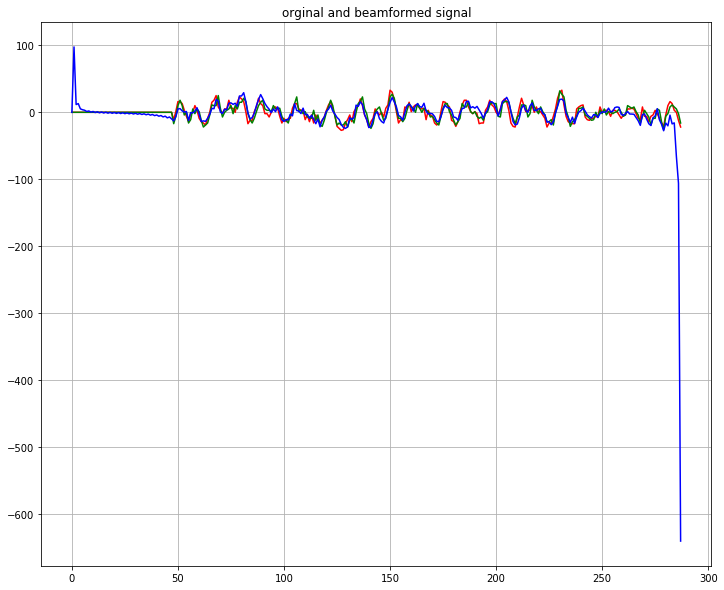

In [77]:
fig = plt.figure(figsize=(12,10))
plt.title("orginal and beamformed signal")
plt.plot(RightChSample, 'r')
plt.plot(LeftChSample, 'g')
plt.plot(output_beamformed, 'b')

#plt.legend(('original', 'filtered'), loc='best')
plt.grid(True)
plt.show()

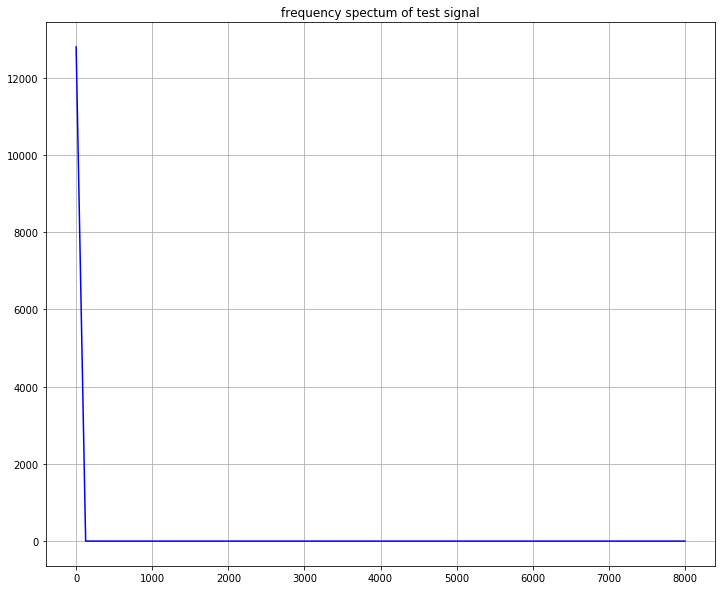

In [17]:
fft_bins = np.fft.rfft(local_input)
freq_indx = np.fft.rfftfreq(fft_len, d=1./fs)
fig = plt.figure(figsize=(12,10))
plt.title("frequency spectum of test signal")
plt.plot(freq_indx, np.abs(fft_bins), 'b')
#plt.plot(apollo_digital_filter_output, 'r')
#plt.legend(('original', 'filtered'), loc='best')
plt.grid(True)
plt.show()